In [1]:
from __future__ import division #always returns approximations from divisions
import numpy as np
import matplotlib.pyplot as plt
import ephem #for astronomy calculations, converting coordinate systems
import pandas as pd
from astroquery.gaia import Gaia

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
v_df = pd.read_csv('voyager1_ephemeris.txt', skiprows = 57, skipfooter=216-165, engine='python') # df of info about voyager's position
s_df = pd.DataFrame(columns = ['source_id', 'g_abs', 'bp_rp', 'parallax']) # df of info about stars

In [3]:
for i in range(len(v_df.index)):
    #query to cone search around given voyager position
    query = """SELECT source_id, phot_g_mean_mag+5*log10(ABS(parallax)/1000)+5 AS g_abs, bp_rp, parallax
    FROM gaiaedr3.gaia_source
    WHERE 1=CONTAINS(
    POINT('ICRS', ra, dec),
    CIRCLE('ICRS', """ + str(v_df['ra'][i]) + """,""" + str(v_df['dec'][i]) + """, 0.035603))
    """
    
    results = Gaia.launch_job_async(query).get_results() #results from gaia query
    results = results.to_pandas().dropna() #convert to pandas

    df_merge = results.merge(s_df, how = 'left', indicator = True) #merge unique stars from results to stars df
    df_merge = df_merge[df_merge._merge == 'left_only'].iloc[:,:-1]
    s_df = pd.concat([s_df, df_merge], ignore_index = True)
    
print(s_df)

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [4]:
s_df.to_csv('voyager1_stars.csv') #save stars

<ipython-input-5-5bf555ceac98>:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("hot"))
  color_map.set_bad(color='white') #set color as white for masked values


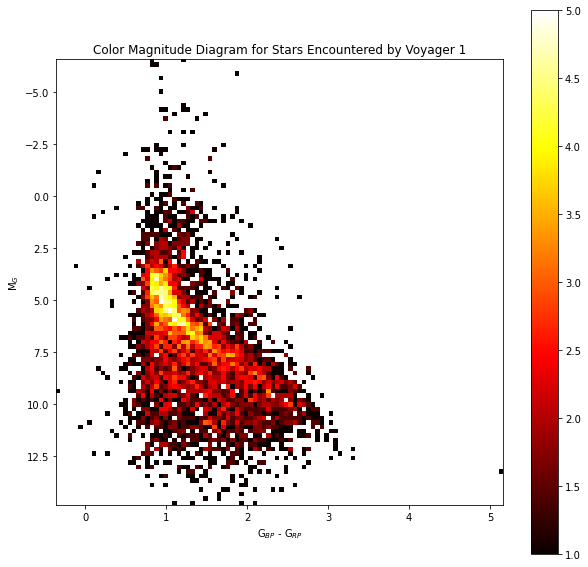

In [5]:
#build hr diagram
histogram, xedges, yedges = np.histogram2d(
   s_df['bp_rp'], s_df['g_abs'], bins=100)

histogram = np.ma.masked_where(histogram == 0.0, histogram) #map zero values
histogram = histogram.T #list bins with common y range

color_map = plt.cm.get_cmap("hot") #set colors for diagram
color_map.set_bad(color='white') #set color as white for masked values

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]] #bounding box in data

#plotting

plt.figure(figsize=(10, 10))

#plt.savefig('gaia_100_parsecs.png')
plt.imshow(np.sqrt(histogram), origin='lower', cmap=color_map,
    extent=extent, aspect=(extent[1]-extent[0])/(extent[3]-extent[2])
    )

plt.colorbar()
plt.title("Color Magnitude Diagram for Stars Encountered by Voyager 1")
plt.xlabel('G$_{BP}$ - G$_{RP}$')
plt.ylabel('M$_G$')
plt.gca().invert_yaxis()
plt.savefig('voyager1_stars_hr.png')

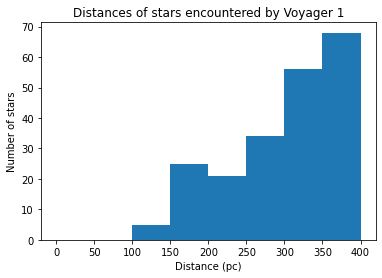

<Figure size 432x288 with 0 Axes>

In [11]:
plt.hist(1/abs((s_df['parallax']/1000)), bins = [0, 50, 100, 150, 200, 250, 300, 350, 400]) #plot parallax (mas) converted to distance (pc) in histogram

plt.title("Distances of stars encountered by Voyager 1") #labels
plt.xlabel("Distance (pc)")
plt.ylabel("Number of stars")

plt.show()
plt.savefig("voyager1_dist_hist.png")